# Predict the wind speed

A summarised set of methods and results

In [163]:
import requests
from pathlib import Path
from tqdm import tqdm
import logging
import re
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import zipfile

from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [164]:
BYTES_MB = 1024 * 1024

In [165]:

def download_file(url: str, outfile: str | Path) -> None:
    """
    Download a file from the web, based on its url, and save to the outfile.

    Args:
        url(:obj:`str`): Url of data to download.
        outfile(:obj:`str` | :obj:`Path`): File path to which the download is saved.
    """

    outfile = Path(outfile).resolve()
    result = requests.get(url, stream=True)

    with outfile.open("wb") as f:
        for chunk in tqdm(result.iter_content(chunk_size=BYTES_MB), desc="MB downloaded"):
            if chunk:
                f.write(chunk)


In [166]:
url = r"https://zenodo.org/records/8252025/files/Kelmarsh_12.3MW_6xSenvion_MM92.kmz?download=1"
outfile = Path("Kelmarsh_12.3MW_6xSenvion_MM92.kmz")

if not outfile.is_file():
    download_file(url,outfile)


In [167]:
url = r"https://zenodo.org/records/8252025/files/Kelmarsh_SCADA_2022_4457.zip?download=1"
outfile = Path("Kelmarsh_SCADA_2022_4457.zip")

if not outfile.is_file():
    download_file(url,outfile)

with zipfile.ZipFile(outfile,"r") as zip_ref:
    zip_ref.extractall()


In [168]:
scada_files = list(Path().rglob("Turbine_Data*.csv"))

In [169]:
use_columns = [
            "# Date and time",
            "Power (kW)",
            "Wind speed (m/s)",
            "Wind direction (°)",
            "Nacelle position (°)",
            "Blade angle (pitch position) A (°)",
        ]

csv_params = {
        "index_col": "# Date and time",
        "parse_dates": True,
        "skiprows": 9,
        "usecols": use_columns,
    }

In [170]:
str(scada_files[0])[-42:-32]

'Kelmarsh_1'

In [171]:
scada_lst = []

for file in scada_files:
    turbine_name = str(file)[-42:-32] # TODO - should take name of file not the full path

    scada_wt = pd.read_csv(file, **csv_params)

    scada_wt["Turbine"] = turbine_name
    scada_wt.index.names = ["Timestamp"]
    scada_lst.append(scada_wt.copy())

scada = pd.concat(scada_lst)

In [172]:
scada

,Wind speed (m/s),Wind direction (°),Nacelle position (°),Power (kW),Blade angle (pitch position) A (°),Turbine
Timestamp,,,,,,
2022-01-01 00:00:00,6.781222,185.795348,193.731354,630.889598,0.0000,Kelmarsh_1
2022-01-01 00:10:00,6.936052,189.458687,193.731354,809.339449,0.0000,Kelmarsh_1
2022-01-01 00:20:00,7.294642,188.648729,193.731354,893.607333,0.0470,Kelmarsh_1
2022-01-01 00:30:00,8.080467,188.826550,193.731354,995.583734,0.0065,Kelmarsh_1
2022-01-01 00:40:00,7.021328,191.252213,193.731354,926.519441,0.0060,Kelmarsh_1
...,...,...,...,...,...,...
2022-12-31 23:10:00,8.712688,210.193670,205.457916,1447.101428,0.1090,Kelmarsh_6
2022-12-31 23:20:00,9.149686,208.465164,205.457916,1572.766687,0.3910,Kelmarsh_6
2022-12-31 23:30:00,9.571797,213.539677,205.457916,1653.457245,1.1805,Kelmarsh_6


In [173]:
scada["Yaw error"] = (scada["Nacelle position (°)"] - scada["Wind direction (°)"]+180)%360-180 # TODO - circular difference rather than absolute

<Axes: xlabel='Timestamp'>

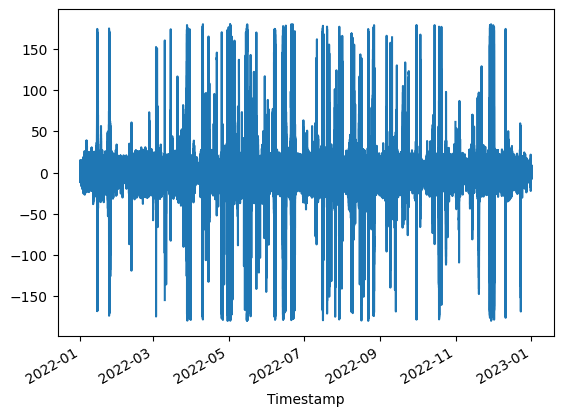

In [174]:
scada["Yaw error"].plot()

In [175]:
target_turbine = "Kelmarsh_1"

In [176]:
scada_clean = scada[(scada["Turbine"]!=target_turbine) | ((scada["Turbine"]==target_turbine) & (scada["Blade angle (pitch position) A (°)"]<1.5) 
                            & (scada["Blade angle (pitch position) A (°)"]>-1.5))]

scada_clean = scada.copy()


In [177]:
scada_clean = scada_clean.pivot(columns='Turbine').dropna().stack("Turbine").reset_index().set_index("Timestamp")

C:\Users\Charlie\AppData\Local\Temp\ipykernel_7032\4243526468.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  scada_clean = scada_clean.pivot(columns='Turbine').dropna().stack("Turbine").reset_index().set_index("Timestamp")


In [178]:
scada_clean

,Turbine,Wind speed (m/s),Wind direction (°),Nacelle position (°),Power (kW),Blade angle (pitch position) A (°),Yaw error
Timestamp,,,,,,,
2022-01-01 00:00:00,Kelmarsh_1,6.781222,185.795348,193.731354,630.889598,0.0000,7.936005
2022-01-01 00:00:00,Kelmarsh_2,6.649725,185.131387,193.410889,630.786577,0.0000,8.279502
2022-01-01 00:00:00,Kelmarsh_3,6.526749,191.038261,191.092590,593.362961,0.0000,0.054329
2022-01-01 00:00:00,Kelmarsh_4,6.736784,185.012514,191.375766,613.850131,0.0000,6.363253
2022-01-01 00:00:00,Kelmarsh_5,5.357348,179.017514,194.111094,306.639859,0.0000,15.093580
...,...,...,...,...,...,...,...
2022-12-31 23:50:00,Kelmarsh_2,10.462493,208.765861,213.166046,1849.897888,2.0080,4.400185
2022-12-31 23:50:00,Kelmarsh_3,8.545551,211.568216,213.043030,1457.414063,0.6200,1.474814
2022-12-31 23:50:00,Kelmarsh_4,9.887900,207.402546,209.195862,1743.388065,1.5725,1.793316


In [179]:
scada_target = scada_clean[scada_clean["Turbine"]==target_turbine]

In [180]:
scada_others = scada_clean[scada_clean["Turbine"]!=target_turbine]

In [181]:
X = scada_others.pivot(columns='Turbine')
y = scada_target

In [182]:
X.columns = [re.sub(r'[^a-zA-Z_0-9]','', '_'.join(map(str, col)).strip()) for col in X.columns]

In [183]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Benchmark

Take the median wind speed from the other turbines

In [184]:
target_feature = "Wind speed (m/s)"

In [185]:
column_windspeeds = X_test.columns[:5]

In [186]:
target_prediction = X_test[column_windspeeds].median(axis=1)

target_prediction.name = "target_prediction"

In [187]:
target_result = pd.concat([X_test,y_test,target_prediction],axis=1)

In [188]:
target_result

,Windspeedms_Kelmarsh_2,Windspeedms_Kelmarsh_3,Windspeedms_Kelmarsh_4,Windspeedms_Kelmarsh_5,Windspeedms_Kelmarsh_6,Winddirection_Kelmarsh_2,Winddirection_Kelmarsh_3,Winddirection_Kelmarsh_4,Winddirection_Kelmarsh_5,Winddirection_Kelmarsh_6,...,Yawerror_Kelmarsh_5,Yawerror_Kelmarsh_6,Turbine,Wind speed (m/s),Wind direction (°),Nacelle position (°),Power (kW),Blade angle (pitch position) A (°),Yaw error,target_prediction
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-09-29 16:30:00,3.894865,4.060944,3.393770,3.411683,2.794071,339.282603,346.729245,337.823116,337.093863,345.265851,...,10.832895,2.875628,Kelmarsh_1,3.817218,343.978192,330.927460,90.902920,0.270500,-13.050732,3.411683
2022-10-27 11:00:00,5.701757,4.431822,4.892803,4.770235,4.079395,192.156701,194.605723,196.554203,197.876651,200.855639,...,-16.779178,-6.372729,Kelmarsh_1,5.657467,190.778119,193.731873,304.483872,0.000000,2.953754,4.770235
2022-01-21 22:40:00,9.775558,9.109201,6.539167,8.941340,7.468666,289.089450,288.957771,289.870108,277.565292,287.067481,...,-3.441726,4.001184,Kelmarsh_1,9.207916,288.890928,282.634094,1731.965649,0.087000,-6.256833,8.941340
2022-04-07 12:30:00,15.503277,15.436545,17.145669,14.820233,12.286878,275.211368,278.445048,275.792482,268.221985,281.599441,...,6.349840,-2.130351,Kelmarsh_1,10.704871,265.387938,264.659398,1943.612537,9.887500,-0.728540,15.436545
2022-07-11 14:40:00,1.981705,1.983600,2.241019,2.282981,2.648745,201.168281,219.293935,206.141479,202.867827,214.584924,...,9.792116,9.093310,Kelmarsh_1,1.806844,209.676108,222.268555,-1.657051,44.990002,12.592447,2.241019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-11 02:10:00,2.787612,2.108348,4.063747,3.735487,4.087024,133.509499,142.855876,127.440841,126.347444,137.302821,...,8.385405,9.984487,Kelmarsh_1,3.616817,131.342535,142.146866,66.745600,0.490000,10.804331,3.735487
2022-07-29 23:30:00,4.461511,4.527772,5.103748,5.609223,4.742726,160.791467,159.511666,146.088954,144.190636,152.739249,...,3.712990,-2.158668,Kelmarsh_1,5.297484,150.483313,153.121994,247.327555,0.000000,2.638681,4.742726
2022-02-03 13:20:00,5.997439,6.097547,7.122160,6.430911,4.701127,241.025212,234.942250,244.551854,227.328653,237.073935,...,13.867972,8.887004,Kelmarsh_1,6.197654,231.289302,235.438812,486.161641,0.000000,4.149510,6.097547


In [189]:
np.mean(abs(target_result["target_prediction"]-target_result[target_feature]))

0.6265498599391742

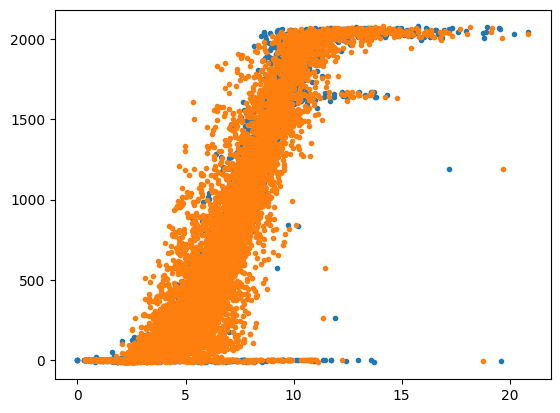

In [190]:
plt.figure()
plt.plot(target_result["Wind speed (m/s)"],target_result["Power (kW)"],marker='.',linestyle='')
plt.plot(target_result["target_prediction"],target_result["Power (kW)"],marker='.',linestyle='')
plt.show()

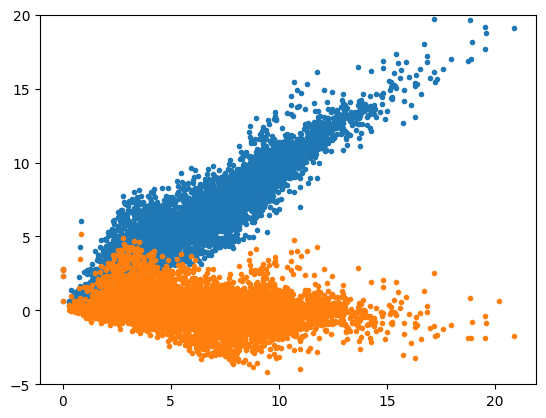

In [191]:
plt.figure()
plt.plot(target_result[target_feature],target_result["target_prediction"],marker='.',linestyle='')
plt.plot(target_result[target_feature],target_result["target_prediction"]-target_result[target_feature],marker='.',linestyle='')
plt.ylim([-5,20])
plt.show()

## Multi-linear model

In [192]:
# Initialize the linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train[target_feature])

LinearRegression()

In [193]:
# Predict the target values for the test set
target_prediction = model.predict(X_test)

In [194]:
target_result = pd.concat([X_test,y_test],axis=1)
target_result["target_prediction"] = target_prediction

np.mean(abs(target_result["target_prediction"]-target_result[target_feature]))

0.5613953087783046

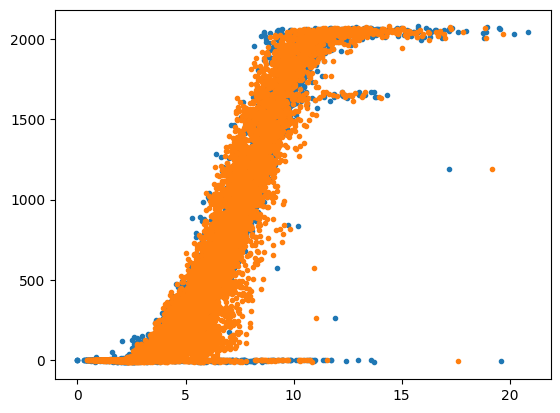

In [195]:
plt.figure()
plt.plot(target_result["Wind speed (m/s)"],target_result["Power (kW)"],marker='.',linestyle='')
plt.plot(target_result["target_prediction"],target_result["Power (kW)"],marker='.',linestyle='')
plt.show()

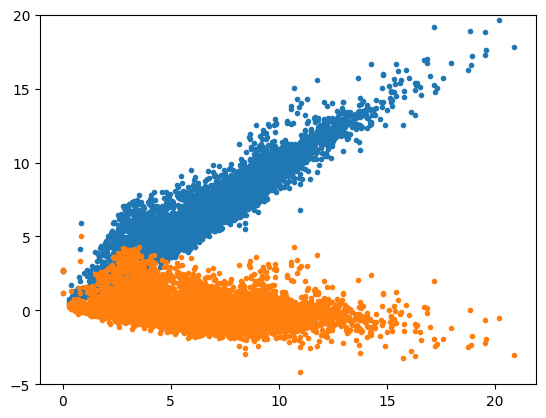

In [196]:
plt.figure()
plt.plot(target_result[target_feature],target_result["target_prediction"],marker='.',linestyle='')
plt.plot(target_result[target_feature],target_result["target_prediction"]-target_result[target_feature],marker='.',linestyle='')
plt.ylim([-5,20])
plt.show()

## Light GBM

In [197]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Initialize LightGBM Regressor
lgb_model = lgb.LGBMRegressor(
    n_estimators=20000,       # Number of trees
    learning_rate=0.005,      # Step size shrinkage
    max_depth=-1,           # No limit on tree depth
    n_jobs=-1,
    random_state=42,         # Reproducibility  
)

# Train the model
lgb_model.fit(X_train, y_train[target_feature], eval_set=[(X_test, y_test[target_feature])], eval_metric='mae')

# Predict
target_prediction = lgb_model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 41266, number of used features: 30
[LightGBM] [Info] Start training from score 5.957971


In [198]:
target_result = pd.concat([X_test,y_test],axis=1)
target_result["target_prediction"] = target_prediction

np.mean(abs(target_result["target_prediction"]-target_result[target_feature]))

0.33333897393998213

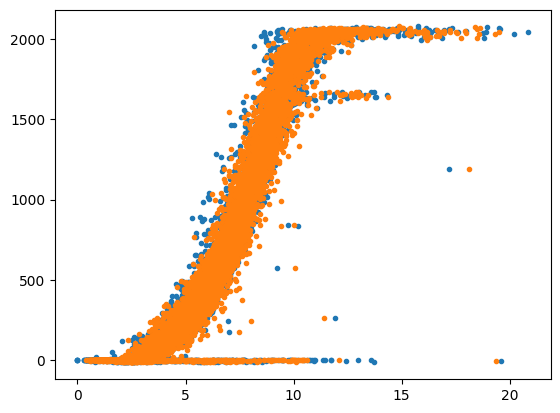

In [199]:
plt.figure()
plt.plot(target_result["Wind speed (m/s)"],target_result["Power (kW)"],marker='.',linestyle='')
plt.plot(target_result["target_prediction"],target_result["Power (kW)"],marker='.',linestyle='')
plt.show()

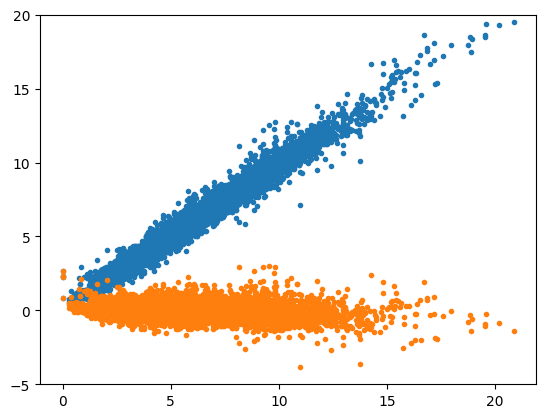

In [200]:
plt.figure()
plt.plot(target_result[target_feature],target_result["target_prediction"],marker='.',linestyle='')
plt.plot(target_result[target_feature],target_result["target_prediction"]-target_result[target_feature],marker='.',linestyle='')
plt.ylim([-5,20])
plt.show()

# AutoML

In [156]:
# Training with AutoGluon
predictor = TabularPredictor(
    label=target_feature, 
    eval_metric='mae'
)
predictor.fit(
    train_data=pd.concat([X_train,y_train[target_feature]],axis=1), 
    time_limit=60*60, 
    presets='best_quality', 
    num_gpus='auto', 
    num_cpus='auto'
)

No path specified. Models will be saved in: "AutogluonModels\ag-20250202_143758"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.2
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       7.48 GB / 15.94 GB (47.0%)
Disk Space Avail:   195.31 GB / 931.51 GB (21.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout 

In [157]:
target_prediction = predictor.predict(X_test)

In [158]:
target_prediction.name = "target_prediction"

In [159]:
target_result = pd.concat([X_test,y_test,target_prediction],axis=1)

np.mean(abs(target_result["target_prediction"]-target_result[target_feature]))

0.316562303449469

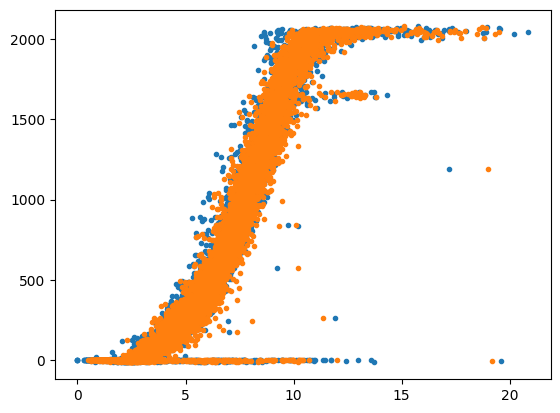

In [160]:
plt.figure()
plt.plot(target_result["Wind speed (m/s)"],target_result["Power (kW)"],marker='.',linestyle='')
plt.plot(target_result["target_prediction"],target_result["Power (kW)"],marker='.',linestyle='')
plt.show()

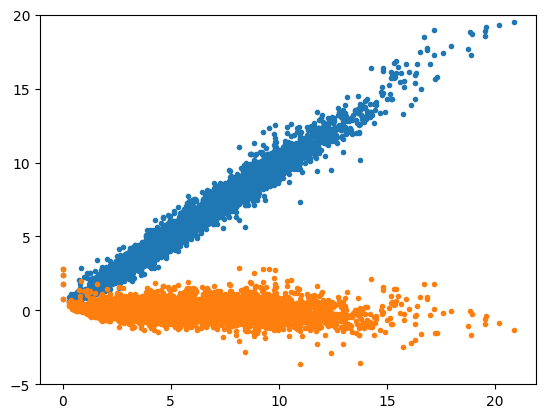

In [162]:
plt.figure()
plt.plot(target_result[target_feature],target_result["target_prediction"],marker='.',linestyle='')
plt.plot(target_result[target_feature],target_result["target_prediction"]-target_result[target_feature],marker='.',linestyle='')
plt.ylim([-5,20])
plt.show()